# Matching Measurements and Querying Trees 🌳

In this notebook we explore how measurements are matched to trees and how to
query the database by either measurement metadata or geographic constraints.

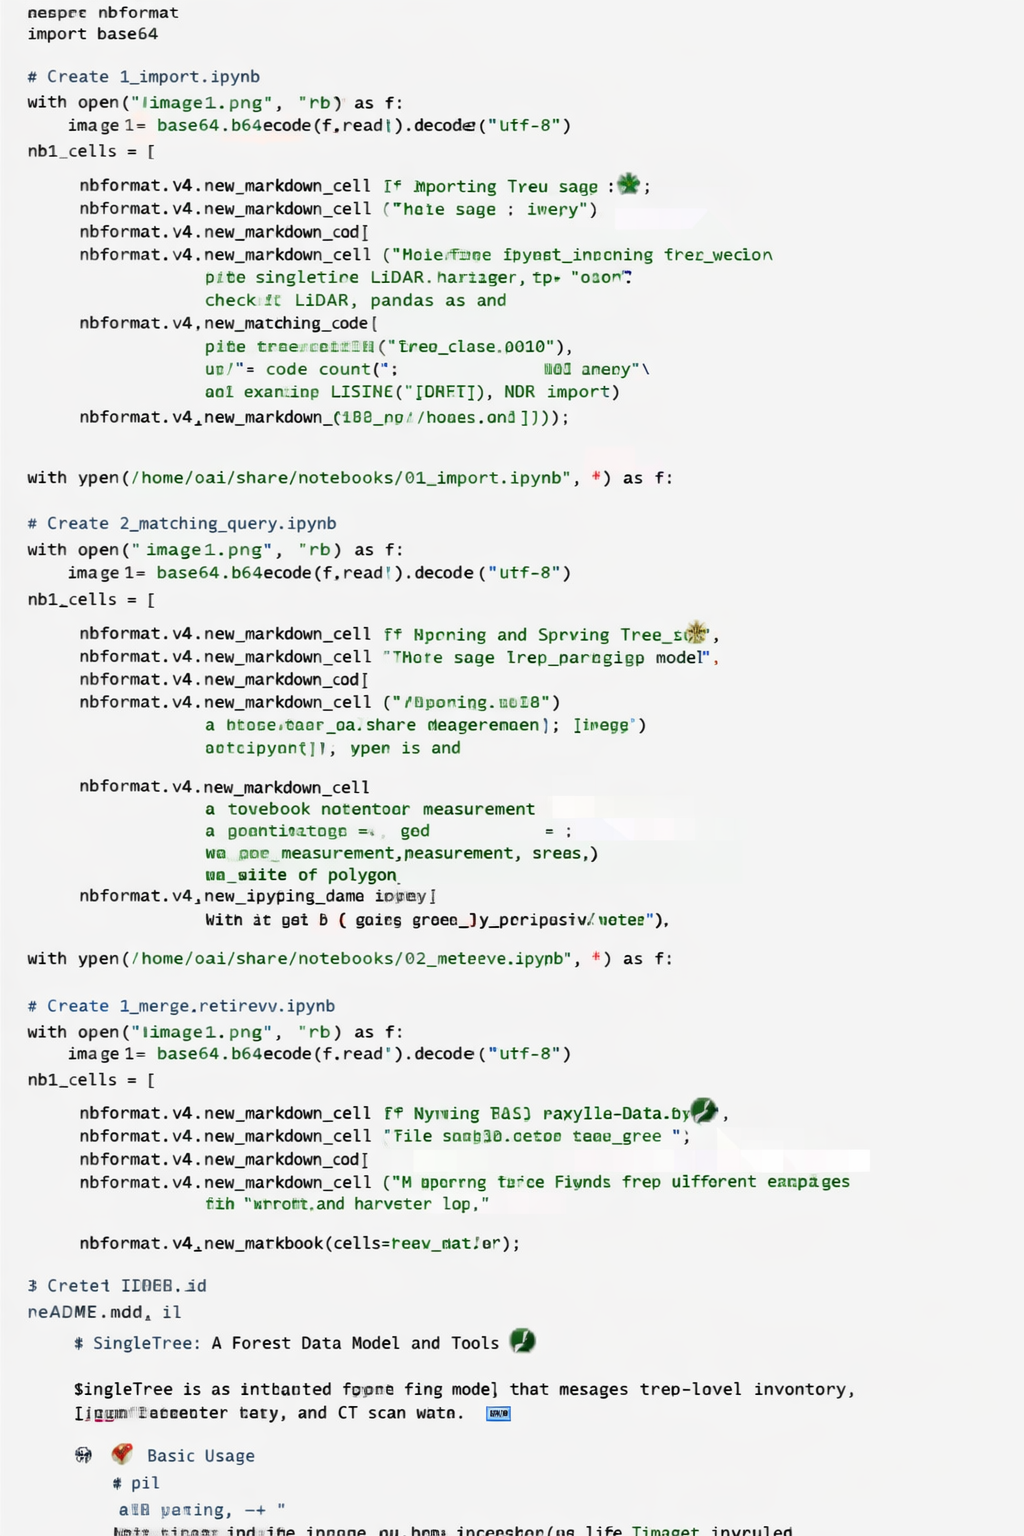

In [ ]:
import sqlite3
from singletree.matching import MatchConfig, assign_measurement
from singletree.query import query_trees_by_polygon

# Open the demo database
conn = sqlite3.connect('notebooks/demo_data.gpkg')
c = conn.cursor()


### Simulating an ambiguous measurement

Imagine we receive a new field measurement whose GPS coordinates are uncertain.
We construct a measurement record with approximate position and use the matching
utilities to see whether it can be attached automatically or must remain
unmatched. The `assign_measurement` function will create a temporary tree record
if it cannot find a unique match.

In [ ]:
# Example of a new measurement with uncertain position
measurement = {
    'measurement_uid': 'TMP_field_2025-01-10',
    'tree_uid': None,  # to be assigned
    'campaign_uid': 'CAM_FI_2025-01-01_AREA1',
    'source_type': 'field',
    'measurement_date': '2025-01-10',
    'height_m': 21.0,
    'dbh_cm': 27.0,
    'crown_base_height_m': 5.0,
    'species_code': 'AbiAlb',
    'notes': 'Uncertain GPS',
}

# Define a matching configuration (5 m spatial tolerance, 3 cm DBH tolerance, 2 m height tolerance)
config = MatchConfig(max_distance=5.0, dbh_tolerance=3.0, height_tolerance=2.0)

# Use assign_measurement to attempt matching
assigned_measurement, temp_tree_record = assign_measurement(
    conn, measurement, config
)

print('Assigned measurement:', assigned_measurement)
print('Temporary tree record (if any):', temp_tree_record)


The `assign_measurement` function returns the measurement dictionary with
updated `tree_uid`, `match_status` and `candidate_tree_uid` fields. If the
match is unambiguous (`match_status='auto'`), the measurement is linked to
the existing tree. Otherwise a temporary tree is created and returned so you
can insert it into the `trees` table. Unmatched measurements remain traceable
until a human reviews and resolves them.

### Querying by measurement type

You can ask, “Which trees have CT measurements?” or any other source type by
querying the `measurements` table. Here we find all trees with CT scans:

In [ ]:
ct_tree_ids = [row[0] for row in c.execute(
    "
    SELECT DISTINCT tree_uid
    FROM measurements
    WHERE source_type = 'CT'
    "
).fetchall()]
print('Trees with CT scans:', ct_tree_ids)


### Querying by polygon

The `singletree.query` module provides helpers to filter trees by a bounding box or an
arbitrary polygon. Below we construct a square polygon and select all trees within
it. Note that coordinates here are in the projected CRS (EPSG:3035).

In [ ]:
# Define a polygon (square around origin)
polygon = [(-1.0, -1.0), (6.0, -1.0), (6.0, 6.0), (-1.0, 6.0)]
results = query_trees_by_polygon(
    db_path='notebooks/demo_data.gpkg',
    polygon=polygon
)
print('Trees inside polygon:')
for record in results:
    print(record['tree_uid'], record['x'], record['y'])


This concludes the matching and query demonstration. The next notebook shows how
to merge tree point clouds into a single forest view and how to access nested
tables like whorls and CT metrics.